In [1]:
!pip install wikipedia-api

In [2]:
!pip install wordcloud

In [3]:
!pip install spacy

In [4]:
!python -m spacy download es_core_news_sm

     --------------------------------------- 12.9/12.9 MB 11.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [5]:
!pip install geopandas

# Creating a wordcloud based Spanish Autonomies Map

## Project Objective

The primary aim of this endeavor is to produce a comprehensive map of Spain, wherein each autonomous community or autonomy is depicted with a wordcloud. These wordclouds will encapsulate the most frequently occurring words found within the corresponding Wikipedia article dedicated to each autonomy.

## Project Methodology

### Scrapping wikipedia links for Spanish Autonomies 

To achieve this objective, the project commenced by generating a list comprising the essential parameters required for interacting with the Wikipedia API. These parameters enable access to the specific Wikipedia articles pertaining to each of the Spanish autonomies. The list of API access links was meticulously derived from an official Wikipedia annex, which featured a comprehensive table containing pertinent information about all the autonomous communities in Spain. This table served as the foundational reference point for our data collection process.

In [6]:
from bs4 import BeautifulSoup
from urllib.parse import unquote
import requests

# Define the URL of the Wikipedia page
page_url = 'https://es.wikipedia.org/wiki/Anexo:Comunidades_y_ciudades_aut%C3%B3nomas_de_Espa%C3%B1a'

# Send an HTTP GET request to retrieve the page content
response = requests.get(page_url)
html_content = response.text

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table in the HTML with a specific class
table = soup.find('table', class_='wikitable')

# Find all rows (table rows) within the table
rows = table.find_all('tr')

# Initialize an empty list to store the extracted links
ccaa_links = []

# Iterate through the rows in the table
for row in rows:
    # Find all cells (table data cells) within the row
    cells = row.find_all('td')

    # Check if the desired column index is within the range of cells
    if 1 < len(cells):
        # Find all links (anchor tags) within the specified column's cell
        links = cells[1].find_all('a', href=True)
        
        # Extract and append all the links within the cell while excluding links ending with '.svg'
        [ccaa_links.append(link['href']) for link in links if not link['href'].endswith('.svg')]

# Drop the last element of the list which is a Spain link
ccaa_links.pop()

# Remove '/wiki/' from the links and decode URL-encoded characters
ccaa_links = [link.replace('/wiki/', '') for link in ccaa_links]
ccaa_links = [unquote(link) for link in ccaa_links]

# Print the decoded links
print(ccaa_links)


['Andalucía', 'Cataluña', 'Comunidad_de_Madrid', 'Comunidad_Valenciana', 'Galicia', 'Castilla_y_León', 'País_Vasco', 'Canarias', 'Castilla-La_Mancha', 'Región_de_Murcia', 'Aragón', 'Islas_Baleares', 'Extremadura', 'Asturias', 'Navarra', 'Cantabria', 'La_Rioja_(España)', 'Melilla', 'Ceuta']


### Compilation of an Autonomy Articles Corpus

In the pursuit of constructing a valuable dataset, the utilization of the Wikipedia API, in conjunction with a curated list of access links, facilitated the acquisition of textual content from each autonomy article. Subsequently, this textual data underwent a systematic preprocessing pipeline.

The preprocessing phase encompassed two key steps:

   - **Stop Word Elimination**: Common stop words from the Spanish language were systematically removed, enhancing the quality and relevance of the text data.

   - **Lemmatization**: The application of lemmatization, a linguistic technique, effectively reduced words to their base or root form. This step standardized the vocabulary and improved the efficiency of subsequent natural language processing (NLP) tasks.

Upon completion of these preprocessing procedures, a comprehensive corpus containing each autonomy article in its refined, preprocessed form was successfully compiled. This meticulously curated corpus now serves as a foundational resource for forthcoming NLP-driven analyses and insights.

In [7]:
import wikipediaapi
import spacy

# Create a Wikipedia API object
wiki_wiki = wikipediaapi.Wikipedia("CCAA World Cloud (lucasbernalespenberger@gmail.com)", 'es')  # Replace 'en' with your desired language code

# List to store the text content of each Wikipedia page
corpus = []

# Load the Spanish language model for spaCy
nlp = spacy.load('es_core_news_sm')

# Iterate through the list of page titles
for title in ccaa_links:
    # Fetch the Wikipedia page based on the title
    page = wiki_wiki.page(title)
    
    # Check if the page exists
    if page.exists():
        # Parse the text content of the Wikipedia page
        doc = nlp(page.text)
        
        # Extract lemmas from the text, removing stopwords and non-alphabetic tokens
        lemmas = [token.lemma_ for token in doc]
        stopwords = spacy.lang.es.stop_words.STOP_WORDS
        alpha_lemmas = [lemma for lemma in lemmas if 
                        lemma.isalpha() and 
                        lemma not in stopwords]

        # Join the lemmas to form the article's text content
        article = ' '.join(alpha_lemmas)
        
        # Append the text content to the corpus list
        corpus.append(article)
        
# Print the total number of articles in the corpus
print(len(corpus))


19


### Word Weighting Comparative Analysis Across Autonomies

Within the corpus, certain words exhibit a notable frequency across all autonomies, with "Spain" being a prominent example. To accentuate words that possess a more distinct presence within each autonomy article relative to others, we employed Tf-Idf (Term Frequency-Inverse Document Frequency) vectorization on the entire article set.

To facilitate the application of these vectors to generate word clouds, we devised a dictionary. In this dictionary, each word was associated with its corresponding value obtained from the Tf-Idf vectorization. This value had been previously multiplied by 100 and converted into a whole number so that it is suitable for wordcloud building. Words that, following this numerical transformation, retained a value of 0 were excluded from the dictionaries.


In [8]:
# Import TF-IDF vectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer with n-gram range (1, 2)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Convert text data (corpus) into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Get the words corresponding to TF-IDF matrix columns
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a dense array
tfidf_matrix_dense = tfidf_matrix.toarray()

# Optionally, create a DataFrame (if you have pandas) for better visualization
import pandas as pd
tfidf_df = pd.DataFrame(data=tfidf_matrix_dense, columns=feature_names)

# Scale values by 100 and round them to integers
df_multiplied_rounded = (tfidf_df * 100).astype(int)

# Display the TF-IDF matrix with values multiplied by 100 and rounded
print(df_multiplied_rounded.head())


   aa  aa población  aa provincia  abac  abac jordi  abad  abad león  \
0   0             0             0     0           0     0          0   
1   0             0             0     0           0     0          0   
2   0             0             0     0           0     0          0   
3   0             0             0     0           0     0          0   
4   0             0             0     0           0     0          0   

   abad san  abades  abades llave  ...  بنو  بنو قاسي  دارجة  \
0         0       0             0  ...    0         0      0   
1         0       0             0  ...    0         0      0   
2         0       0             0  ...    0         0      0   
3         0       0             0  ...    0         0      0   
4         0       0             0  ...    0         0      0   

   دارجة generalizado  قاسي  قاسي dominio  مدينة  مدينة التراب  ḥuṣūn  \
0                   0     0             0      0             0      0   
1                   0     0         

In [9]:
# Create empty list to store dictionaries with word frequencies
result_dicts = []

# Iterate through each row of the DataFrame
for index, row in df_multiplied_rounded.iterrows():
    # Initialize an empty dictionary for each row
    row_dict = {}
    
    # Iterate through each column
    for col_name, col_value in row.items():
        # Check if the column value is not zero (filtering out zero values)
        if col_value != 0:
            # Add the column name as the key and its value to the row dictionary
            row_dict[col_name] = col_value
    
    # Append the row dictionary to the result_dicts list
    result_dicts.append(row_dict)

# Print the list of dictionaries, each representing non-zero values in a row
print(result_dicts[0])


{'abstención': 1, 'abundante': 1, 'actividad': 2, 'actual': 1, 'actualidad': 1, 'actualmente': 1, 'adulto': 2, 'agrario': 1, 'agricultura': 1, 'agroalimentario': 1, 'alcanzar': 1, 'algeciras': 1, 'alhambra': 1, 'alimentación': 1, 'almería': 9, 'almería granada': 1, 'alta': 1, 'alto': 1, 'ambiental': 1, 'andalucía': 54, 'andalucía alcanzar': 1, 'andalucía comunidad': 1, 'andalucía contar': 3, 'andalucía dividir': 1, 'andalucía encontrar': 1, 'andalucía poseer': 1, 'andalucía región': 1, 'andalucía sede': 1, 'andalusí': 2, 'andaluz': 36, 'andaluz andalucía': 1, 'andaluza': 5, 'animal': 1, 'anual': 1, 'aportar': 2, 'aportar producción': 1, 'aporte': 1, 'aprobar': 1, 'aprovechamiento': 1, 'arquitectura': 2, 'arquitectura tradicional': 1, 'arte': 1, 'artículo': 1, 'artículo constitución': 1, 'asamblea': 1, 'asimismo': 1, 'atlántico': 2, 'aumento': 1, 'autogobierno': 1, 'autonomía': 3, 'autonomía andalucía': 2, 'autonómico': 2, 'autor': 1, 'autóctono': 1, 'autónomo': 4, 'año': 4, 'baeza': 1,

### Generation of Autonomy-Shaped Word Clouds

The subsequent phase involved the creation of word clouds, each uniquely shaped to represent the geographical contours of Spanish autonomies. To achieve this, it was imperative to obtain geospatial information for Spain and its autonomous regions, enabling the generation of masks that would correspond to the specific shape of each autonomy.

The geographical map data for Spain was sourced and downloaded from the [Centro de Descargas del CNIG (IGN)](https://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=CAANE). It is worth noting that data for the Spanish Peninsula and the Balearic Islands was separate from that of the Canary Islands. Both datasets were meticulously imported, standardized to harmonize their geometry parameters, and subsequently merged into a cohesive dataset.

Leveraging this unified dataset, we extracted the distinctive shapes of each autonomy, exporting them as PNG files. To ensure accurate pairing of these PNG autonomy shapes with the corresponding autonomy texts for word cloud creation, a comprehensive dictionary was crafted. This dictionary facilitated mapping the indices of each autonomy in the corpus to their counterparts in the GeoPandas dataframe and PNG files.

The PNGs, representing the distinct shapes of each autonomy, were then employed as masks in the word cloud generation process. The resulting word clouds, fashioned in the likeness of Spanish autonomies, were exported as PNG files, aligning with the geographical context from which their constituent words originated.

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a file path for the GeoData of the peninsula together with balearics (peninbal) and the canary islands
file_path_p = './peninbal/recintos_autonomicas_inspire_peninbal_etrs89.shp'
file_path_c = './canarias/recintos_autonomicas_inspire_canarias_regcan95.shp'

# Read the files with geopandas and transform the geometry of canaries to match peninbal
peninbal = gpd.read_file(file_path_p)
canaries = gpd.read_file(file_path_c)
canaries = canaries.to_crs('ETRS89')

# Merge both dataframes and reset indexes
map = pd.concat([peninbal, canaries], axis=0)
map = map.reset_index(drop=True)

# Iterate through each row in the GeoDataFrame
for index, row in map.iterrows():

    # Create a plot of the current province
    fig, ax = plt.subplots(figsize=(8, 8))
    map[index : index + 1].plot(ax=ax)

    # Remove axis for a clean plot
    ax.axis('off')

    # Export the plot as an image with the province name as the filename
    output_filename = f'./CCAA_pngs/{index}.png'
    plt.savefig(output_filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.close()  # Close the current plot to release resources

# Print a message indicating that the export is complete
print('Province plots exported successfully.')


Province plots exported successfully.


In [11]:
# Display the order of autonomies in the links/corpus list and in the gpd dataframe
display(ccaa_links)
display(map['NAMEUNIT'])

# Define a mapping between indices in the gdp df and the order of corpus articles
index_gdp_vs_wc = {0: 0,
                  1: 10,
                  2: 13,
                  3: 11, 
                  4: 15,
                  5: 5,
                  6: 8,
                  7: 1,
                  8: 3,
                  9: 12,
                  10: 4,
                  11: 2, 
                  12: 9, 
                  13: 14,
                  14: 6,
                  15: 16,
                  16: 18,
                  17: 17,
                  19: 7}

['Andalucía',
 'Cataluña',
 'Comunidad_de_Madrid',
 'Comunidad_Valenciana',
 'Galicia',
 'Castilla_y_León',
 'País_Vasco',
 'Canarias',
 'Castilla-La_Mancha',
 'Región_de_Murcia',
 'Aragón',
 'Islas_Baleares',
 'Extremadura',
 'Asturias',
 'Navarra',
 'Cantabria',
 'La_Rioja_(España)',
 'Melilla',
 'Ceuta']

0                                      Andalucía
1                                         Aragón
2                         Principado de Asturias
3                                  Illes Balears
4                                      Cantabria
5                                Castilla y León
6                             Castilla-La Mancha
7                             Cataluña/Catalunya
8                           Comunitat Valenciana
9                                    Extremadura
10                                       Galicia
11                           Comunidad de Madrid
12                              Región de Murcia
13                    Comunidad Foral de Navarra
14                            País Vasco/Euskadi
15                                      La Rioja
16                      Ciudad Autónoma de Ceuta
17                    Ciudad Autónoma de Melilla
18    Territorio no asociado a ninguna autonomía
19                                      Canarias
Name: NAMEUNIT, dtyp

In [12]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

# Iterate through the mapping
for i, (key, value) in enumerate(index_gdp_vs_wc.items()):
    # Load a mask image corresponding to the shape of the autonomy
    mask = np.array(Image.open(f'./CCAA_pngs/{key}.png'))

    # Create a WordCloud object with the mask and custom color
    wordcloud = WordCloud(width=800, height=400, mode="RGBA", background_color=None, mask=mask)

    # Generate the word cloud from the text data
    wordcloud.generate_from_frequencies(result_dicts[value])

    # Display the word cloud
    plt.figure(figsize=(16, 16))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Export the plot as an image with the province name as the filename
    wordcloud.to_file(f'./CCAA_pngs_wc/{key}.png')
    plt.close()  # Close the current plot to release resources


### Integration of Autonomy Word Clouds into the Spain Map

In the final phase of the project, a comprehensive visual representation was generated by plotting all the autonomies onto a unified map. This mapping was accomplished by utilizing the geometry parameters derived from the geopandas dataframe in conjunction with the geographical borders of each autonomy.

The resulting map showcased the word cloud representations of autonomies within the Spanish Peninsula and the Balearic Islands. Recognizing the relatively modest dimensions of Ceuta and Melilla, individual maps were dedicated to each of these autonomous cities to make their word clouds readable. Similarly, given the considerable geographical distance, the Canary Islands were given their own distinct map.

To ensure the legibility and visual coherence of each word cloud, the maps were exported in sizes tailored to the specific characteristics of the autonomies and their associated word clouds. This final visual representation serves as a compelling and informative synthesis of the project's findings and insights.

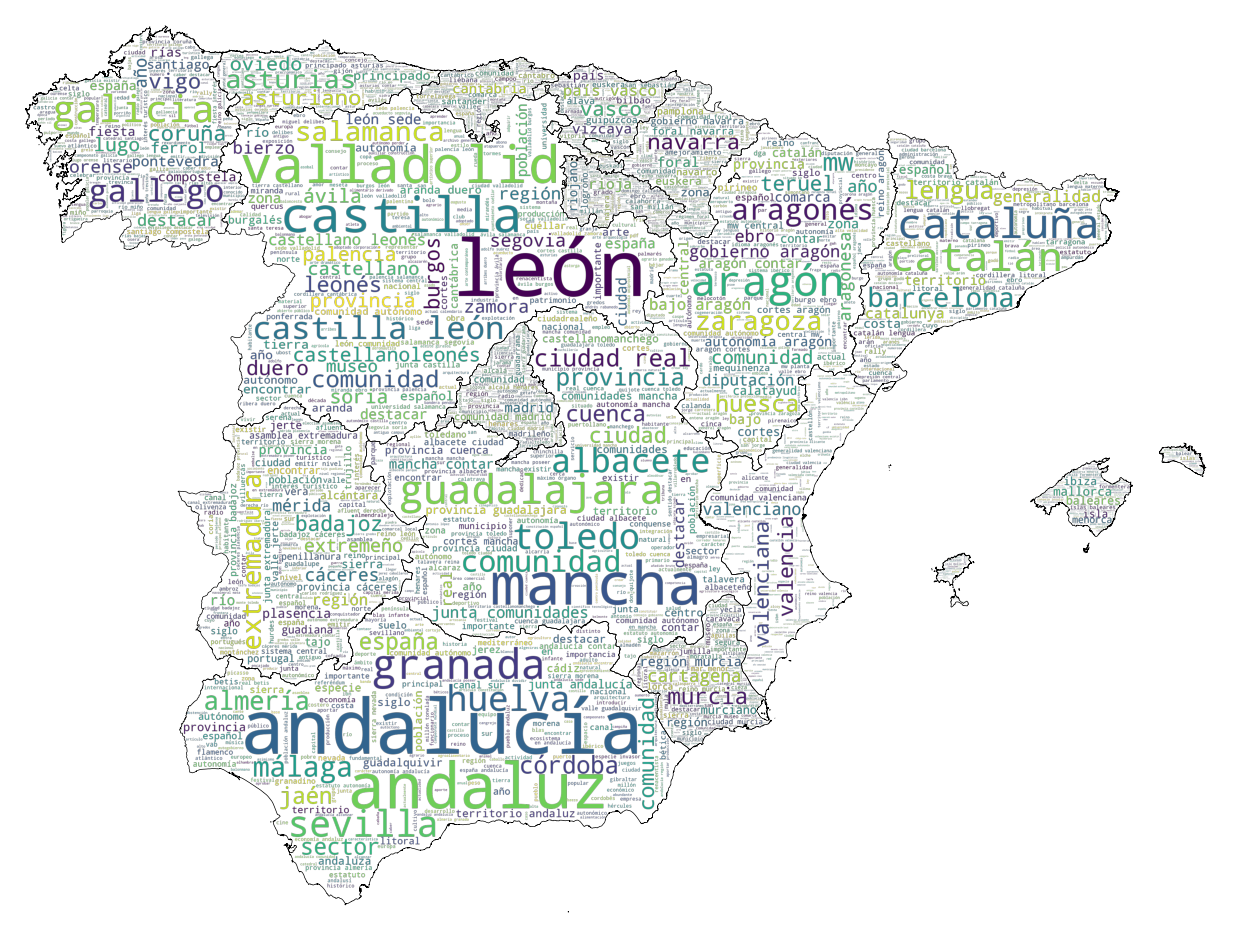

In [13]:
# Create a figure and axis with a manageable canvas size
fig, ax = plt.subplots(figsize=(20, 12)) 

# Create for loop to iterate through all autonomies exluding ceuta, melilla and other territories
for i in range(16):
    # Imoprt and load the wordcloud for the autonomy
    image_filename = f'./CCAA_pngs_wc/{i}.png'
    image = plt.imread(image_filename)
    
    # Get the geometry of the autnomy row
    country_geom = map[i:i+1]['geometry'].values[0]
    
    # Define factors to adjust the size of the images
    size_factor = 1.07
    
    # Create extent values to compensate for distortion of wordclouds compared to map
    extent = (
    country_geom.bounds[0] - (size_factor - 1) * (country_geom.bounds[2] - country_geom.bounds[0]),
    country_geom.bounds[2] + (size_factor - 1) * (country_geom.bounds[2] - country_geom.bounds[0]),
    country_geom.bounds[1] - (size_factor - 1) * (country_geom.bounds[3] - country_geom.bounds[1]),
    country_geom.bounds[3] + (size_factor - 1) * (country_geom.bounds[3] - country_geom.bounds[1])
    )

    # Plot the first image using the corrected geometry values
    ax.imshow(image, extent=extent, zorder=-1)

# Plot the country boundaries
peninsula = map.drop([16, 17, 18, 19])
peninsula.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Remove axis from the figure, save it and display it
plt.axis('off')
plt.savefig('./final_maps/peninsula_and_balearics.jpg', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()

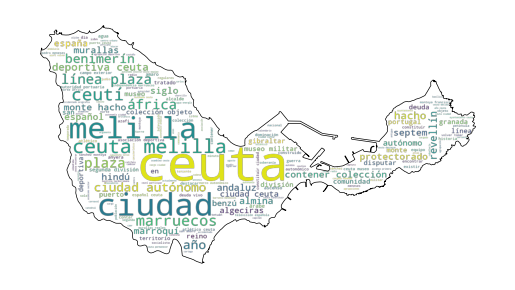

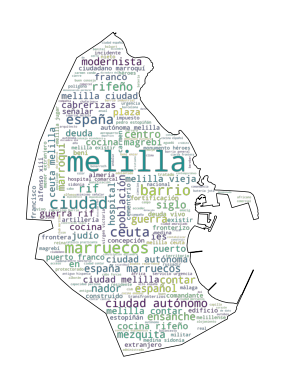

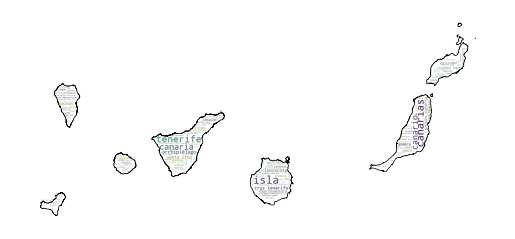

In [14]:
# Define a dictionary with non-peninsular regions and their corresponding keys
non_peninsular = {16: 'ceuta', 17: 'melilla', 19: 'canaries'}

# Iterate through the non-peninsular regions
for key, value in non_peninsular.items():

    # Define the image filenames for the word clouds
    image_filename = f'./CCAA_pngs_wc/{key}.png'
    
    # Load the image
    image = plt.imread(image_filename)
    
    # Get the geometry (boundary) of the current region
    country_geom = map[key:key+1]['geometry'].values[0]
    
    # Define a size factor to adjust the size of the images
    size_factor = 1.07
    
    # Calculate the extent (bounding box) for the image placement
    extent = (
        country_geom.bounds[0] - (size_factor - 1) * (country_geom.bounds[2] - country_geom.bounds[0]),
        country_geom.bounds[2] + (size_factor - 1) * (country_geom.bounds[2] - country_geom.bounds[0]),
        country_geom.bounds[1] - (size_factor - 1) * (country_geom.bounds[3] - country_geom.bounds[1]),
        country_geom.bounds[3] + (size_factor - 1) * (country_geom.bounds[3] - country_geom.bounds[1])
    )

    # Plot the boundary of the country in black with a specified line width
    map.boundary.plot(color='black', linewidth=0.5)
    
    # Display the word cloud image on top of the country with the adjusted size
    plt.imshow(image, extent=extent, zorder=-1, aspect=1.2)    

    # Turn off axis labels
    plt.axis('off')
    
    # Save the final map as an image with proper settings
    plt.savefig(f'./final_maps/{value}.jpg', bbox_inches='tight', pad_inches=0.1, dpi=900)
    
    # Show the map
    plt.show()
